<a href="https://colab.research.google.com/github/danon6868/BI-ml-2024/blob/main/lecture_8_pytorch/homework/FC_NN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [1]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
import warnings

# добавила чтобы было более красиво:)
warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
# Устанавливаем seed для PyTorch
torch.manual_seed(42)

# Устанавливаем seed для numpy
np.random.seed(42)

# Устанавливаем seed для random
random.seed(42)

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [4]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [5]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


<font color="#e8851c"> **Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?**


<font color="darkblue">
**Ответ:** Чем больше размер batch_size, тем быстрее будет проходить обучение, так как будет уменьшатсья количество иттераций для обучения нейронной сети (обновление весов происходит реже). Если смотреть анологии - это как уменьшать параметр кросс-валидации

Посмотрим на какую-нибудь картинку:

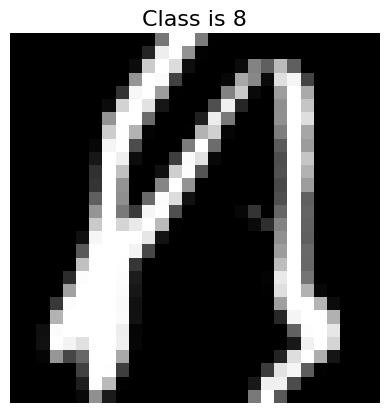

In [6]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





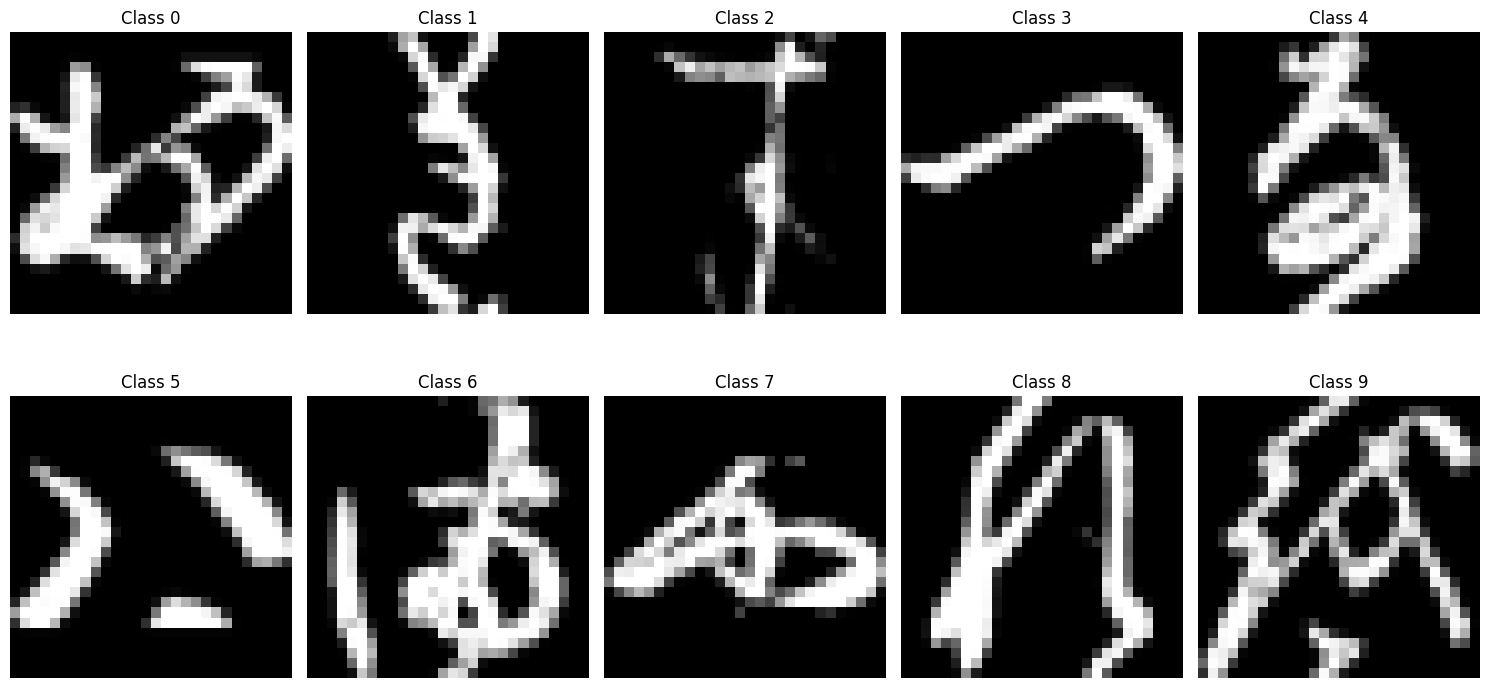

In [7]:
# Создание списка для хранения по одному примеру из каждого класса
samples_per_class = [None] * 10

# Находим по одному примеру из каждого класса
for i in range(len(trainset)):
    image, label = trainset[i]
    if samples_per_class[label] is None:
        samples_per_class[label] = image
        if all(sample is not None for sample in samples_per_class):
            break

# Отображение изображений всех классов на одном графике
plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(samples_per_class[i].view(28, 28).numpy(), cmap="gray")
    plt.axis("off")
    plt.title(f"Class {i}", fontsize=12)
plt.tight_layout()
plt.show()

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.

https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [8]:
import torch.nn as nn

class FCNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__() #  это надо помнить!
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.activation = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы
        # Преобразование входного тензора в плоский вектор
        x = x.view(x.size(0), -1)
        # print(x.shape)
        # Проход через первый полносвязный слой с активацией
        x = self.activation(self.fc1(x))

        # Проход через второй полносвязный слой с активацией
        x = self.activation(self.fc2(x))

        # Проход через третий полносвязный слой без активации (последний слой)
        x = self.fc3(x)

        # Применение Softmax к последнему слою для получения вероятностного вывода
        logits = self.softmax(x)

        return logits

<font color="#e8851c"> **Сколько обучаемых параметров у вашей модели (весов и смещений)?**


<font color="darkblue"> **Ответ:**
Для этого надо будет рассчитать: Количество входных признаков × количество выходных признаков (веса) +
Количество выходных признаков (смещения)



<font color="darkblue"> (784×256+256×128+128×10)+(256+128+10) = 200704 + 32768 + 1280 + 394 = **235146** **обучаемых** **параметров**

### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [9]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total

    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [10]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [11]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    # Переводим модель в режим обучения
    fc_net.train()  # Переводим модель в режим обучения

    running_loss = 0.0
    correct = 0
    total = 0

    # Проходим по тренировочным данным
    for inputs, labels in trainloader:
        # print(inputs, labels)
        # Обнуляем градиенты
        optimizer.zero_grad()

        # Прямой проход
        outputs = fc_net(inputs)

        # Вычисляем loss
        loss = loss_function(outputs, labels)

        # Обратный проход и оптимизация
        loss.backward() # вычисляются градиенты функции потерь по параметрам модели с использованием алгоритма обратного распространения ошибки (backpropagation)
        optimizer.step() #делаем шаг по оптимизации

        # Считаем статистики
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Выводим статистику после каждой эпохи, чат ГПТ подсказал)
    print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss/len(trainloader):.4f}, Accuracy: {(100*correct/total):.2f}%')

Epoch [1/10], Loss: 1.8534, Accuracy: 65.23%
Epoch [2/10], Loss: 1.6664, Accuracy: 80.83%
Epoch [3/10], Loss: 1.6466, Accuracy: 82.36%
Epoch [4/10], Loss: 1.6362, Accuracy: 83.18%
Epoch [5/10], Loss: 1.6277, Accuracy: 83.94%
Epoch [6/10], Loss: 1.6201, Accuracy: 84.67%
Epoch [7/10], Loss: 1.6139, Accuracy: 85.25%
Epoch [8/10], Loss: 1.6083, Accuracy: 85.78%
Epoch [9/10], Loss: 1.6029, Accuracy: 86.30%
Epoch [10/10], Loss: 1.5979, Accuracy: 86.78%


In [12]:
get_accuracy(fc_net, testloader)

0.7083

<font color="#e8851c"> **Какое значение `accuracy` на тестовой выборке удалось получить?**

<font color="darkblue"> Accuracy логично растет с каждой эпохой. При этом на тестовой выборке accuracy равно **0.7083**

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [13]:
# Получаем первый элемент из набора данных
sample_image, _ = trainset[0]

# Печатаем размер тензора (изображения)
print("Size of sample image:", sample_image.size())
print('Trainset len', len(trainset))

Size of sample image: torch.Size([1, 28, 28])
Trainset len 60000


In [14]:
mean = 0.0
std = 0.0
total_samples = len(trainset) #60 000 как раз
for image, _ in trainset:
    mean += torch.mean(image)
    std += torch.std(image)

mean /= total_samples
std /= total_samples
print('mean = ', mean, '\nstd = ', std)

mean =  tensor(0.1918) 
std =  tensor(0.3385)


In [15]:
# mean = ## calculate mean
# std = ## calculate std
# print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm #данные будут подаваться в нормализованном виде, потому что теперь trainset использует трансформацию transform_with_norm, которая включает в себя операцию нормализации.
testset.transform = transform_with_norm

In [16]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [17]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):

    fc_net.train()

    running_loss = 0.0
    correct = 0
    total = 0


    for inputs, labels in trainloader:
        optimizer.zero_grad()
        outputs = fc_net(inputs)
        loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss/len(trainloader):.4f}, Accuracy: {(100*correct/total):.2f}%')


Epoch [1/10], Loss: 1.7614, Accuracy: 74.75%
Epoch [2/10], Loss: 1.6371, Accuracy: 83.24%
Epoch [3/10], Loss: 1.6124, Accuracy: 85.48%
Epoch [4/10], Loss: 1.5880, Accuracy: 87.92%
Epoch [5/10], Loss: 1.5720, Accuracy: 89.54%
Epoch [6/10], Loss: 1.5608, Accuracy: 90.60%
Epoch [7/10], Loss: 1.5518, Accuracy: 91.46%
Epoch [8/10], Loss: 1.5451, Accuracy: 92.11%
Epoch [9/10], Loss: 1.5401, Accuracy: 92.53%
Epoch [10/10], Loss: 1.5360, Accuracy: 92.88%


In [18]:
get_accuracy(fc_net, testloader)

0.8064

Как изменилась `accuracy` после нормализации?

<font color="#e8851c"> **Как изменилась `accuracy` после нормализации?**

<font color="darkblue"> Accuracy заметно подрос -- почти на 0,1. Был 0.7083, стал **0,8064**

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [19]:
import torch.nn.functional as F

In [20]:
class FCNetDiffer_Activation(nn.Module):
    def __init__(self, activation_func, num_classes=10):
        super().__init__() #  это надо помнить!
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.activation = activation_func
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        logits = self.softmax(x)

        return logits

<font color="#e8851c"> **Для начала применим фнукцию активации sigmoid**

In [21]:
n_epochs = 10
loss_history = []

fc_net_sigmoid = FCNetDiffer_Activation(F.sigmoid)
loss_function = nn.CrossEntropyLoss()
lr = 0.00
optimizer = torch.optim.Adam(fc_net_sigmoid.parameters(), lr=3e-4)


for epoch in range(n_epochs):
    fc_net_sigmoid.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in trainloader:
        optimizer.zero_grad()
        outputs = fc_net_sigmoid(inputs)
        loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss/len(trainloader):.4f}, Accuracy: {(100*correct/total):.2f}%')

Epoch [1/10], Loss: 2.1135, Accuracy: 41.57%
Epoch [2/10], Loss: 1.8661, Accuracy: 62.45%
Epoch [3/10], Loss: 1.7752, Accuracy: 71.70%
Epoch [4/10], Loss: 1.7169, Accuracy: 76.30%
Epoch [5/10], Loss: 1.6945, Accuracy: 78.30%
Epoch [6/10], Loss: 1.6347, Accuracy: 85.51%
Epoch [7/10], Loss: 1.6088, Accuracy: 87.06%
Epoch [8/10], Loss: 1.5952, Accuracy: 88.06%
Epoch [9/10], Loss: 1.5851, Accuracy: 88.90%
Epoch [10/10], Loss: 1.5768, Accuracy: 89.63%


In [22]:
sigmoid_accuracy = get_accuracy(fc_net_sigmoid, testloader)
print('Accuracy при использовании функции активации sigmoid на тестовых данных', sigmoid_accuracy)

Accuracy при использовании функции активации sigmoid на тестовых данных 0.7743


<font color="#e8851c"> **Теперь применим фнукцию активации GELU**

Немного оставлю тут информации про GELU

GELU(x)=x⋅Φ(x),
где
Φ(x) - функция накопленного распределения Гаусса

Главное преимущество GELU по сравнению с ReLU заключается в том, что она обеспечивает более плавное градиентное падение для отрицательных значений, что может помочь в предотвращении проблемы затухающих градиентов.

In [23]:
n_epochs = 10
loss_history = []


fc_net_gelu = FCNetDiffer_Activation(F.gelu)
loss_function = nn.CrossEntropyLoss()

lr = 0.001
optimizer = torch.optim.Adam(fc_net_gelu.parameters(), lr=3e-4)


for epoch in range(n_epochs):
    fc_net_gelu.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in trainloader:

        optimizer.zero_grad()
        outputs = fc_net_gelu(inputs)
        loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss/len(trainloader):.4f}, Accuracy: {(100*correct/total):.2f}%')

Epoch [1/10], Loss: 1.7553, Accuracy: 74.87%
Epoch [2/10], Loss: 1.6136, Accuracy: 85.67%
Epoch [3/10], Loss: 1.5854, Accuracy: 88.41%
Epoch [4/10], Loss: 1.5690, Accuracy: 89.91%
Epoch [5/10], Loss: 1.5571, Accuracy: 91.04%
Epoch [6/10], Loss: 1.5484, Accuracy: 91.85%
Epoch [7/10], Loss: 1.5405, Accuracy: 92.59%
Epoch [8/10], Loss: 1.5334, Accuracy: 93.28%
Epoch [9/10], Loss: 1.5279, Accuracy: 93.75%
Epoch [10/10], Loss: 1.5239, Accuracy: 94.09%


In [24]:
gelu_accuracy = get_accuracy(fc_net_gelu, testloader)
print('Accuracy при использовании функции активации gelu на тестовых данных', gelu_accuracy)

Accuracy при использовании функции активации gelu на тестовых данных 0.8196


<font color="#e8851c"> **Теперь применим фнукцию активации гиперболический  тангенс**

In [25]:
n_epochs = 10
loss_history = []

fc_net_tanh = FCNetDiffer_Activation(torch.tanh)
loss_function = nn.CrossEntropyLoss()
lr = 0.00
optimizer = torch.optim.Adam(fc_net_tanh.parameters(), lr=3e-4)


for epoch in range(n_epochs):
    fc_net_tanh.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in trainloader:
        optimizer.zero_grad()
        outputs = fc_net_tanh(inputs)
        loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss/len(trainloader):.4f}, Accuracy: {(100*correct/total):.2f}%')

Epoch [1/10], Loss: 1.7942, Accuracy: 74.81%
Epoch [2/10], Loss: 1.6370, Accuracy: 84.21%
Epoch [3/10], Loss: 1.5944, Accuracy: 88.06%
Epoch [4/10], Loss: 1.5603, Accuracy: 91.27%
Epoch [5/10], Loss: 1.5412, Accuracy: 93.02%
Epoch [6/10], Loss: 1.5268, Accuracy: 94.32%
Epoch [7/10], Loss: 1.5165, Accuracy: 95.20%
Epoch [8/10], Loss: 1.5070, Accuracy: 96.10%
Epoch [9/10], Loss: 1.4967, Accuracy: 97.07%
Epoch [10/10], Loss: 1.4903, Accuracy: 97.59%


In [26]:
tanh_accuracy = get_accuracy(fc_net_tanh, testloader)
print('Accuracy при использовании функции активации гиперболического тангенса на тестовых данных', tanh_accuracy)

Accuracy при использовании функции активации гиперболического тангенса на тестовых данных 0.8905


С использованием какой функции активации удалось досчить наибольшей `accuracy`?

In [27]:
print('Accuracy при использовании функции активации RELU на тестовых данных', get_accuracy(fc_net, testloader))
print('Accuracy при использовании функции активации sigmoid на тестовых данных', sigmoid_accuracy)
print('Accuracy при использовании функции активации gelu на тестовых данных', gelu_accuracy)
print('Accuracy при использовании функции активации гиперболического тангенса на тестовых данных', tanh_accuracy)

Accuracy при использовании функции активации RELU на тестовых данных 0.8064
Accuracy при использовании функции активации sigmoid на тестовых данных 0.7743
Accuracy при использовании функции активации gelu на тестовых данных 0.8196
Accuracy при использовании функции активации гиперболического тангенса на тестовых данных 0.8905


<font color="#e8851c"> **С использованием какой функции активации удалось досчить наибольшей `accuracy`?**

<font color="darkblue"> На тестовых данных лучше всего себя показал гиперболический тангенс.

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [41]:
class FCNetTanh(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__() #  это надо помнить!
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.activation = torch.tanh
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        logits = self.softmax(x)

        return logits

<font color="#e8851c"> **Для начала применим оптимизатор Adam**

In [29]:
# Создадим объект модели
fc_net_adam = FCNetTanh()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net_adam.parameters(), lr=3e-4)

In [30]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    fc_net_adam.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in trainloader:
        optimizer.zero_grad()

        # Прямой проход
        outputs = fc_net_adam(inputs)
        loss = loss_function(outputs, labels)

        # Обратный проход и оптимизация
        loss.backward()
        optimizer.step()

        # Считаем статистики
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss/len(trainloader):.4f}, Accuracy: {(100*correct/total):.2f}%')

Epoch [1/10], Loss: 1.7887, Accuracy: 75.49%
Epoch [2/10], Loss: 1.6307, Accuracy: 84.81%
Epoch [3/10], Loss: 1.5868, Accuracy: 88.88%
Epoch [4/10], Loss: 1.5590, Accuracy: 91.37%
Epoch [5/10], Loss: 1.5404, Accuracy: 93.06%
Epoch [6/10], Loss: 1.5266, Accuracy: 94.33%
Epoch [7/10], Loss: 1.5123, Accuracy: 95.69%
Epoch [8/10], Loss: 1.5026, Accuracy: 96.56%
Epoch [9/10], Loss: 1.4959, Accuracy: 97.09%
Epoch [10/10], Loss: 1.4907, Accuracy: 97.53%


In [31]:
adam_accuracy = get_accuracy(fc_net_adam, testloader)
print('Accuracy при использовании метода оптимизации Adam на тестовых данных', adam_accuracy)

Accuracy при использовании метода оптимизации Adam на тестовых данных 0.8862


<font color="#e8851c"> **Теперь применим оптимизатор RMSprop**

Если во время проверки у вас будет время, скажите пожалуйста - а создавать объект модели лучше каждый раз новый при замене оптимизатора или достаточно просто переопределить оптимизатор?

In [32]:
# Создадим объект модели
fc_net_rms = FCNetTanh()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.RMSprop(fc_net_rms.parameters(), lr=3e-4)

n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    fc_net_rms.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in trainloader:
        optimizer.zero_grad()

        # Прямой проход
        outputs = fc_net_rms(inputs)
        loss = loss_function(outputs, labels)

        # Обратный проход и оптимизация
        loss.backward()
        optimizer.step()

        # Считаем статистики
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss/len(trainloader):.4f}, Accuracy: {(100*correct/total):.2f}%')

Epoch [1/10], Loss: 1.7004, Accuracy: 79.76%
Epoch [2/10], Loss: 1.6159, Accuracy: 85.80%
Epoch [3/10], Loss: 1.5884, Accuracy: 88.25%
Epoch [4/10], Loss: 1.5692, Accuracy: 90.08%
Epoch [5/10], Loss: 1.5557, Accuracy: 91.27%
Epoch [6/10], Loss: 1.5460, Accuracy: 92.11%
Epoch [7/10], Loss: 1.5382, Accuracy: 92.72%
Epoch [8/10], Loss: 1.5093, Accuracy: 95.78%
Epoch [9/10], Loss: 1.4979, Accuracy: 96.85%
Epoch [10/10], Loss: 1.4919, Accuracy: 97.38%


In [33]:
rms_accuracy = get_accuracy(fc_net_rms, testloader)
print('Accuracy при использовании метода оптимизации RMSprop на тестовых данных', rms_accuracy)

Accuracy при использовании метода оптимизации RMSprop на тестовых данных 0.8699


<font color="#e8851c"> **Теперь применим оптимизатор Adagrad**

In [34]:
# Создадим объект модели
fc_net_adagrad = FCNetTanh()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adagrad(fc_net_adagrad.parameters(), lr=3e-4)

n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    fc_net_adagrad.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in trainloader:
        optimizer.zero_grad()

        # Прямой проход
        outputs = fc_net_adagrad(inputs)
        loss = loss_function(outputs, labels)

        # Обратный проход и оптимизация
        loss.backward()
        optimizer.step()

        # Считаем статистики
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss/len(trainloader):.4f}, Accuracy: {(100*correct/total):.2f}%')

Epoch [1/10], Loss: 2.0642, Accuracy: 62.23%
Epoch [2/10], Loss: 1.9064, Accuracy: 71.81%
Epoch [3/10], Loss: 1.8462, Accuracy: 74.04%
Epoch [4/10], Loss: 1.8123, Accuracy: 75.47%
Epoch [5/10], Loss: 1.7899, Accuracy: 76.38%
Epoch [6/10], Loss: 1.7740, Accuracy: 76.98%
Epoch [7/10], Loss: 1.7619, Accuracy: 77.45%
Epoch [8/10], Loss: 1.7520, Accuracy: 77.91%
Epoch [9/10], Loss: 1.7443, Accuracy: 78.20%
Epoch [10/10], Loss: 1.7374, Accuracy: 78.51%


In [35]:
adagrad_accuracy = get_accuracy(fc_net_adagrad, testloader)
print('Accuracy при использовании метода оптимизации Adagrad на тестовых данных', adagrad_accuracy)

Accuracy при использовании метода оптимизации Adagrad на тестовых данных 0.6157


<font color="#e8851c"> **Посмотрим accuracy достигнутый за 10 эпох обучения для тестовых данных**

<font color="darkblue"> На тестовых данных лучше всего себя показал Adam.

In [36]:
print('Accuracy при использовании метода оптимизации Adam на тестовых данных', adam_accuracy)
print('Accuracy при использовании метода оптимизации RMSprop на тестовых данных', rms_accuracy)
print('Accuracy при использовании метода оптимизации Adagrad на тестовых данных', adagrad_accuracy)

Accuracy при использовании метода оптимизации Adam на тестовых данных 0.8862
Accuracy при использовании метода оптимизации RMSprop на тестовых данных 0.8699
Accuracy при использовании метода оптимизации Adagrad на тестовых данных 0.6157


### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [37]:
class CustomReLU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # YOUR CODE HERE
        # если элемент x < 0, то 0, если >= 0, то x
        return torch.max(x, torch.tensor(0.0))


In [38]:
class FCNetCustom(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__() #  это надо помнить!
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.activation = CustomReLU()
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        logits = self.softmax(x)

        return logits

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [46]:
# Создадим объект модели
fc_net_custom_relu = FCNetCustom()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net_custom_relu.parameters(), lr=3e-4)

n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    fc_net_custom_relu.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in trainloader:
        optimizer.zero_grad()

        # Прямой проход
        outputs = fc_net_custom_relu(inputs)
        loss = loss_function(outputs, labels)

        # Обратный проход и оптимизация
        loss.backward()
        optimizer.step()

        # Считаем статистики
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss/len(trainloader):.4f}, Accuracy: {(100*correct/total):.2f}%')

Epoch [1/10], Loss: 1.7590, Accuracy: 74.62%
Epoch [2/10], Loss: 1.6342, Accuracy: 83.50%
Epoch [3/10], Loss: 1.6138, Accuracy: 85.33%
Epoch [4/10], Loss: 1.5976, Accuracy: 86.93%
Epoch [5/10], Loss: 1.5752, Accuracy: 89.20%
Epoch [6/10], Loss: 1.5615, Accuracy: 90.55%
Epoch [7/10], Loss: 1.5527, Accuracy: 91.35%
Epoch [8/10], Loss: 1.5466, Accuracy: 91.93%
Epoch [9/10], Loss: 1.5412, Accuracy: 92.40%
Epoch [10/10], Loss: 1.5374, Accuracy: 92.75%


In [47]:
custom_relu_accuracy = get_accuracy(fc_net_custom_relu, testloader)
print('Accuracy при использовании CustomRelu на тестовых данных', custom_relu_accuracy)

Accuracy при использовании CustomRelu на тестовых данных 0.8025


In [43]:
class FCNetReLu(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__() #  это надо помнить!
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.activation = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        logits = self.softmax(x)

        return logits

In [44]:
# Создадим объект модели
fc_net_relu = FCNetReLu()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net_relu.parameters(), lr=3e-4)

n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    fc_net_relu.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in trainloader:
        optimizer.zero_grad()

        # Прямой проход
        outputs = fc_net_relu(inputs)
        loss = loss_function(outputs, labels)

        # Обратный проход и оптимизация
        loss.backward()
        optimizer.step()

        # Считаем статистики
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss/len(trainloader):.4f}, Accuracy: {(100*correct/total):.2f}%')

Epoch [1/10], Loss: 1.7654, Accuracy: 74.25%
Epoch [2/10], Loss: 1.6347, Accuracy: 83.48%
Epoch [3/10], Loss: 1.6037, Accuracy: 86.49%
Epoch [4/10], Loss: 1.5807, Accuracy: 88.70%
Epoch [5/10], Loss: 1.5668, Accuracy: 90.05%
Epoch [6/10], Loss: 1.5575, Accuracy: 90.92%
Epoch [7/10], Loss: 1.5496, Accuracy: 91.61%
Epoch [8/10], Loss: 1.5397, Accuracy: 92.68%
Epoch [9/10], Loss: 1.5324, Accuracy: 93.34%
Epoch [10/10], Loss: 1.5275, Accuracy: 93.80%


In [45]:
relu_accuracy = get_accuracy(fc_net_relu, testloader)
print('Accuracy при использовании стандартной Relu на тестовых данных', relu_accuracy)

Accuracy при использовании стандартной Relu на тестовых данных 0.8151


Accuracy похож на custom и стандартном  ReLu - их отличия можно объяснить просто различием в разбиении эпох (так как при каждом прогони, даже с фиксацией seed каждая иттерация немного меняет исходное состояние для следующей)

### Задание 8. Генерация картинок

**3** балла

Придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

<font color="#e8851c"> **Бот не работает, попробую [kandinsky](https://rudalle.ru/check_kandinsky22/f94213b7-7083-42f7-a5e4-46753b02a657)**


<font color="darkblue">
Рыбки самураи плавают в космосе

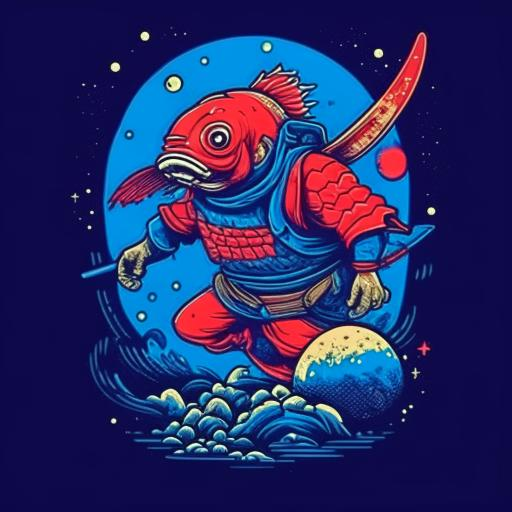

<font color="darkblue">
Две шиншиллы поздравляют с днем рождения

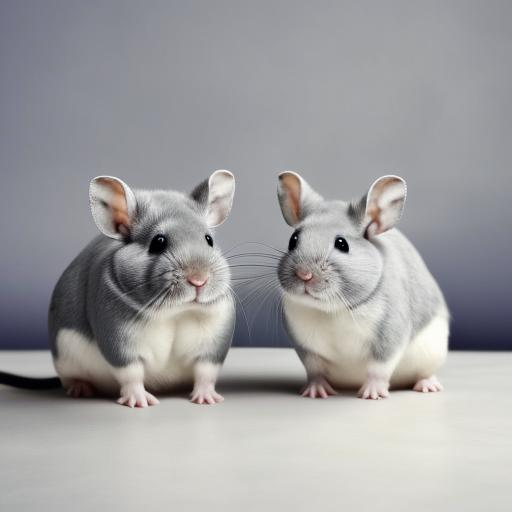

<font color="darkblue">
Много студентов института биоинформатики сдали все на 5 и радуются

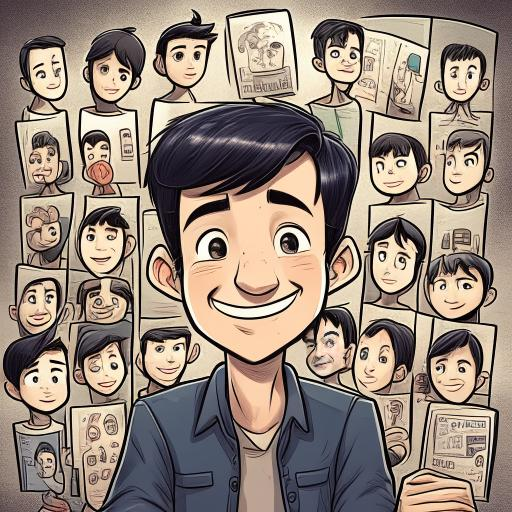